['startdiorallyolov8n_float16serial_data.txt', 'startdiorallyolov8n_int8serial_data.txt', 'startdiorallyolov8s_float16serial_data.txt', 'startdiorallyolov8s_int8serial_data.txt', 'startdiorshipyolov8n_float16serial_data.txt', 'startdiorshipyolov8n_int8serial_data.txt', 'startdiorshipyolov8s_float16serial_data.txt', 'startdiorshipyolov8s_int8serial_data.txt', 'startyolov5n-diorall-fp16serial_data.txt', 'startyolov5n-diorall-int8serial_data.txt', 'startyolov5n-diorship-fp16serial_data.txt', 'startyolov5n-diorship-int8serial_data.txt', 'startyolov5s-diorall-fp16serial_data.txt', 'startyolov5s-diorall-int8serial_data.txt', 'startyolov5s-diorship-fp16serial_data.txt', 'startyolov5s-diorship-int8serial_data.txt', 'z-startyolov5n-diorall-int8_edgetpuserial_data.txt', 'z-startyolov5n-diorship-int8_edgetpuserial_data.txt', 'z-startyolov5s-diorall-int8_edgetpuserial_data.txt', 'z-startyolov5s-diorship-int8_edgetpuserial_data.txt']


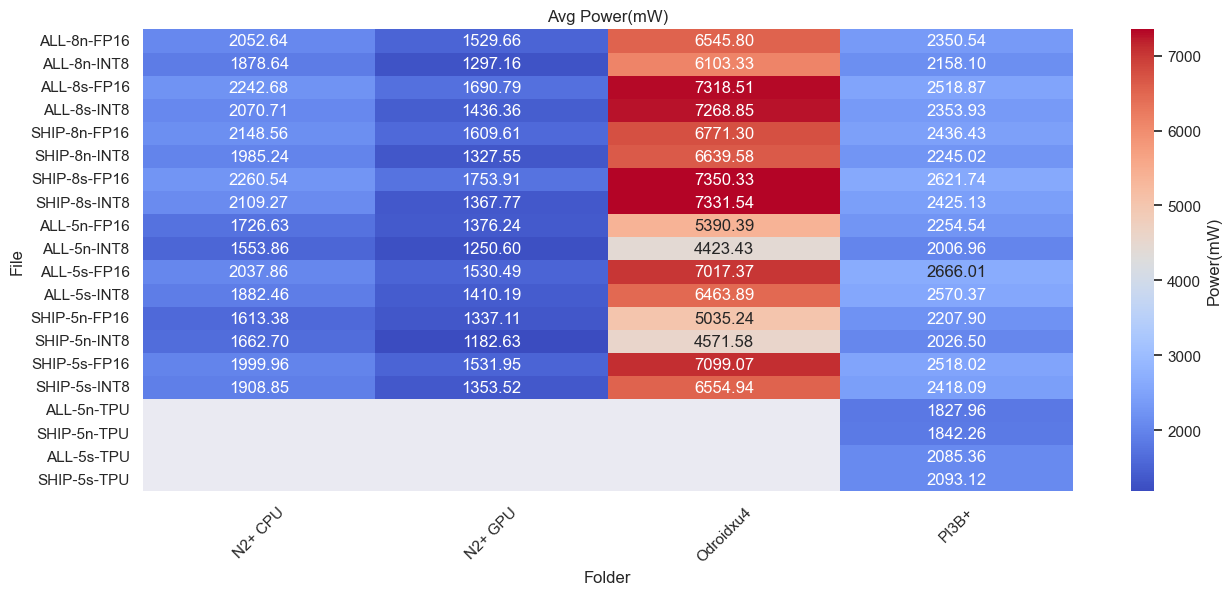

In [69]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def read_inference_files_in_folder(folder_path):
    all_data = []
    filenames = []
    for file in os.listdir(folder_path):
        if file.endswith('.txt') and 'start' in file:
            filepath = os.path.join(folder_path, file)
            with open(filepath, 'r') as f:
                lines = f.readlines()
                data = []
                for line in lines:
                    values = line.strip().split(',')
                    if len(values) == 15:
                        try:
                            data.append([float(x) for x in values if x != ''])
                        except ValueError:
                            continue
                all_data.append(pd.DataFrame(data))
                filenames.append(file)
    return all_data, filenames

def get_avg_highest_power(folder_name, dataframes, top_n=10):
    column = folder_power_column_index[folder_name]
    folder_values = []
    for df in dataframes:
        highest_values = df[column].nlargest(top_n).tolist()
        adjusted_values = [value - avg_standby_power[folder_name] for value in highest_values]
        folder_values.append(np.mean(adjusted_values))
    return folder_values
def get_median_new_data(folder_name, dataframes):
    column = folder_column_index[folder_name]
    folder_values = []
    for df in dataframes:
        median_value = df[column].median()
        adjusted_value = median_value - avg_standby_power[folder_name]
        folder_values.append(adjusted_value)
    return folder_values

def get_avg_power(folder_name, dataframes):
    column = folder_power_column_index[folder_name]
    folder_values = []
    for df in dataframes:
        mean_value = df[column].mean()
        adjusted_value = mean_value - avg_standby_power[folder_name]
        folder_values.append(adjusted_value)
    return folder_values

avg_standby_power = {
    'n2+cpupower': 2244.686,
    'cputhenGPU':2244.686,
    'fullgpu': 2244.686,
    'odroidxu4power': 2877.658,
    'pi3b+cpupower': 2244.667,
}

folder_power_column_index = {
    'n2+cpupower':12,
    'cputhenGPU':12,
    'fullgpu':12,
    'odroidxu4power':12,
    'pi3b+cpupower': 7,
}

folders = ['n2+cpupower','fullgpu', 'odroidxu4power', 'pi3b+cpupower']

all_avg_highest_power = []
file_names_list = []

max_files = 20
for folder in folders:
    data, filenames = read_inference_files_in_folder(folder)
    avg = get_avg_power(folder, data) 
    max_files = max(max_files, len(avg))
    all_avg_highest_power.append(avg)
    file_names_list.append(filenames)


for i in range(len(all_avg_highest_power)):
    if len(all_avg_highest_power[i]) < max_files:
        all_avg_highest_power[i].extend([np.nan] * (max_files - len(all_avg_highest_power[i])))

heatmap_data = np.array(all_avg_highest_power)

unique_filenames = []
for filenames in file_names_list:
    for filename in filenames:
        if filename not in unique_filenames:
            unique_filenames.append(filename)

print(unique_filenames)

def create_heatmap(data, title, ylabel, xlabel, xticklabels, yticklabels, cbar_label):
    plt.figure(figsize=(15, 6))
    ax = sns.heatmap(data, annot=True, cmap="coolwarm", cbar_kws={'label': cbar_label}, fmt='.2f')  # Added the fmt parameter
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_xticklabels(xticklabels, rotation=45)
    ax.set_yticklabels(yticklabels, rotation=0)
    plt.show()


custom_y_labels = ['ALL-8n-FP16', 'ALL-8n-INT8', 'ALL-8s-FP16', 'ALL-8s-INT8', 'SHIP-8n-FP16', 'SHIP-8n-INT8', 'SHIP-8s-FP16', 'SHIP-8s-INT8','ALL-5n-FP16', 'ALL-5n-INT8', 'ALL-5s-FP16', 'ALL-5s-INT8', 'SHIP-5n-FP16', 'SHIP-5n-INT8', 'SHIP-5s-FP16', 'SHIP-5s-INT8','ALL-5n-TPU','SHIP-5n-TPU','ALL-5s-TPU','SHIP-5s-TPU']

heatmap_df = pd.DataFrame(heatmap_data, columns=unique_filenames)
index1 = 10
index2 = 12
index3 = 11
index4 = 13

heatmap_df[[unique_filenames[index1], unique_filenames[index2]]] = heatmap_df[[unique_filenames[index2], unique_filenames[index1]]]
heatmap_df[[unique_filenames[index3], unique_filenames[index4]]] = heatmap_df[[unique_filenames[index4], unique_filenames[index3]]]

unique_filenames[index1], unique_filenames[index2] = unique_filenames[index2], unique_filenames[index1]
unique_filenames[index3], unique_filenames[index4] = unique_filenames[index4], unique_filenames[index3]

heatmap_df = heatmap_df.T

unique_folder_names = ['N2+ CPU','N2+ GPU', 'Odroidxu4', 'PI3B+']

create_heatmap(heatmap_df, "Avg Power(mW)", "File", "Folder", unique_folder_names, custom_y_labels, "Power(mW)")

heatmap_df.to_csv('csvfolders/avg_power_full.csv')



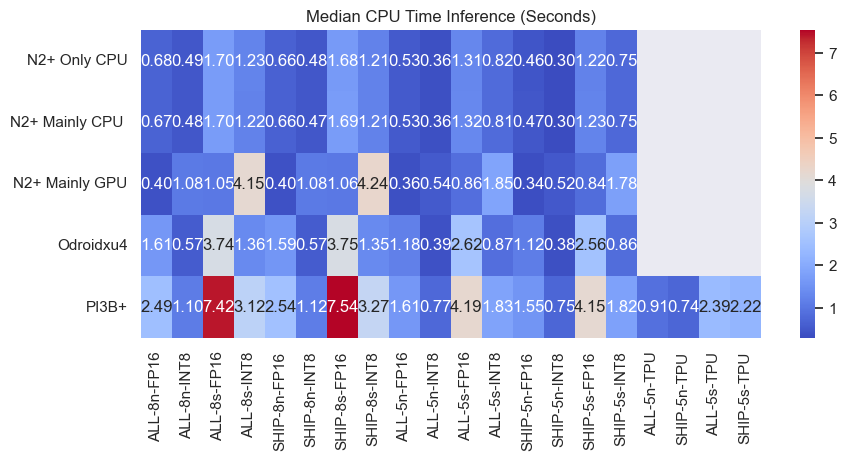

In [155]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def read_new_files_in_folder(folder_path):
    all_data = []
    filenames = []
    for file in os.listdir(folder_path):
        if file.endswith('.txt'):
            filepath = os.path.join(folder_path, file)
            with open(filepath, 'r') as f:
                lines = f.readlines()
                data = []
                for line in lines:
                    values = line.strip().split(' ')
                    if len(values) == 3:
                        try:
                            data.append([values[0], float(values[1]), float(values[2])])
                        except ValueError:
                            continue
                all_data.append(pd.DataFrame(data, columns=['Type', 'CPUTime', 'WallClockTime']))
                filenames.append(file)
    return all_data, filenames

def get_avg_highest_new_data(dataframes, data_type='inference', time_type='CPUTime', top_n=10):
    folder_values = []
    for df in dataframes:
        filtered_df = df[df['Type'] == data_type]
        highest_values = filtered_df[time_type].nlargest(top_n).tolist()
        folder_values.append(np.mean(highest_values))
    return folder_values

def get_avg_new_data(dataframes, data_type='inference', time_type='CPUTime'):
    folder_values = []
    for df in dataframes:
        filtered_df = df[df['Type'] == data_type]
        avg_value = filtered_df[time_type].mean()
        folder_values.append(avg_value)
    return folder_values

def get_median_new_data(dataframes, data_type='inference', time_type='CPUTime'):
    folder_values = []
    for df in dataframes:
        filtered_df = df[df['Type'] == data_type]
        median_value = filtered_df[time_type].median()
        folder_values.append(median_value)
    return folder_values


folders = ['time/n2+cputime/logtime','time/n2+cputhengpu/logfiletime', 'time/n2+gputime/logtime', 'time/odroidxu4time/logfiletime', 'time/pi3b+time/logfiletime']

all_avg_highest_memory = []
filenames_list = []

max_files = 0

for folder in folders:
    data, filenames = read_new_files_in_folder(folder)
    avg = get_avg_new_data(data, time_type='WallClockTime')  # Changed the function and time_type parameter
    max_files = max(max_files, len(avg))
    all_avg_highest_memory.append(avg)
    filenames_list.append(filenames)


for i in range(len(all_avg_highest_memory)):
    if len(all_avg_highest_memory[i]) < max_files:
        all_avg_highest_memory[i].extend([np.nan] * (max_files - len(all_avg_highest_memory[i])))

heatmap_data = np.array(all_avg_highest_memory)

unique_filenames = []
for filenames in filenames_list:
    for filename in filenames:
        if filename not in unique_filenames:
            unique_filenames.append(filename)

heatmap_df = pd.DataFrame(heatmap_data, columns=unique_filenames)
index1 = 10
index2 = 12
index3 = 11
index4 = 13

heatmap_df[[unique_filenames[index1], unique_filenames[index2]]] = heatmap_df[[unique_filenames[index2], unique_filenames[index1]]]
heatmap_df[[unique_filenames[index3], unique_filenames[index4]]] = heatmap_df[[unique_filenames[index4], unique_filenames[index3]]]

# Swap the corresponding x-labels in the unique_filenames list
unique_filenames[index1], unique_filenames[index2] = unique_filenames[index2], unique_filenames[index1]
unique_filenames[index3], unique_filenames[index4] = unique_filenames[index4], unique_filenames[index3]

custom_y_labels = ['N2+ Only CPU','N2+ Mainly GPU', 'Odroidxu4', 'PI3B+']

plt.figure(figsize=(10, 4))
heatmap = sns.heatmap(heatmap_df, annot=True, cmap='coolwarm', fmt='.2f', yticklabels=custom_y_labels)


plt.title('Median CPU Time Inference (Seconds)')

box_width = 1

custom_x_labels = unique_filenames  # Use filenames as x labels

custom_x_labels = ['ALL-8n-FP16', 'ALL-8n-INT8', 'ALL-8s-FP16', 'ALL-8s-INT8', 'SHIP-8n-FP16', 'SHIP-8n-INT8', 'SHIP-8s-FP16', 'SHIP-8s-INT8','ALL-5n-FP16', 'ALL-5n-INT8', 'ALL-5s-FP16', 'ALL-5s-INT8', 'SHIP-5n-FP16', 'SHIP-5n-INT8', 'SHIP-5s-FP16', 'SHIP-5s-INT8','ALL-5n-TPU','SHIP-5n-TPU','ALL-5s-TPU','SHIP-5s-TPU']

heatmap.set_xticks(np.arange(heatmap_data.shape[1]) + box_width / 2)
heatmap.set_xticklabels(custom_x_labels, rotation=90)
plt.savefig('median_CPUTIME_heatmap.jpeg', format='jpeg', dpi=1000)
plt.show()

folder_names = ['N2+ Only CPU', 'N2+ Mainly CPU ','N2+ Mainly GPU', 'Odroidxu4', 'PI3B+']
heatmap_df.index = folder_names

extension = "_walltime"

# Add the extension word to each string in the list
custom_x_labels = [string + extension for string in custom_x_labels]


heatmap_df.columns = custom_x_labels
heatmap_df.to_csv('csvfolders/avg_WALLCLOCK_inference_data.csv')


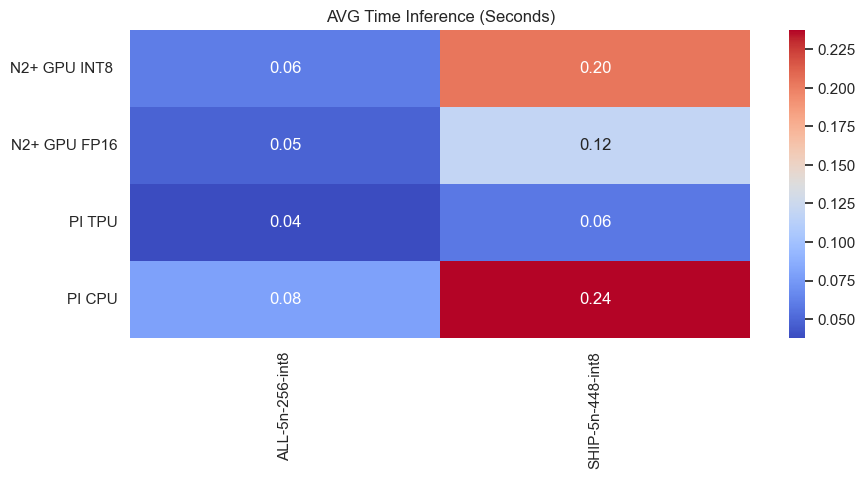

In [130]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def read_new_files_in_folder(folder_path):
    all_data = []
    filenames = []
    for file in os.listdir(folder_path):
        if file.endswith('.txt'):
            filepath = os.path.join(folder_path, file)
            with open(filepath, 'r') as f:
                lines = f.readlines()
                data = []
                for line in lines:
                    values = line.strip().split(' ')
                    if len(values) == 3:
                        try:
                            data.append([values[0], float(values[1]), float(values[2])])
                        except ValueError:
                            continue
                all_data.append(pd.DataFrame(data, columns=['Type', 'CPUTime', 'WallClockTime']))
                filenames.append(file)
    return all_data, filenames

def get_avg_highest_new_data(dataframes, data_type='inference', time_type='WallClockTime', top_n=10):
    folder_values = []
    for df in dataframes:
        filtered_df = df[df['Type'] == data_type]
        highest_values = filtered_df[time_type].nlargest(top_n).tolist()
        folder_values.append(np.mean(highest_values))
    return folder_values

def get_avg_new_data(dataframes, data_type='inference', time_type='WallClockTime'):
    folder_values = []
    for df in dataframes:
        filtered_df = df[df['Type'] == data_type]
        avg_value = filtered_df[time_type].mean()
        folder_values.append(avg_value)
    return folder_values

def get_median_new_data(dataframes, data_type='inference', time_type='WallClockTime'):
    folder_values = []
    for df in dataframes:
        filtered_df = df[df['Type'] == data_type]
        median_value = filtered_df[time_type].median()
        folder_values.append(median_value)
    return folder_values

folders = ['time/tpu/gpucomparison/logtime','time/tpu/gpucomaprisonfp16/timelogs', 'time/tpu/tpustd/logfiletime','time/tpu/cpucomparison/timelogs']

max_files = 0
filename_column_indices = {}
current_column_index = 0


all_avg_highest_memory = []
filenames_list = []

max_files = 0
for folder in folders:
    data, filenames = read_new_files_in_folder(folder)
    avg = get_avg_new_data(data, time_type='WallClockTime')
    max_files = max(max_files, len(avg))
    all_avg_highest_memory.append(avg)
    filenames_list.append(filenames)

for i in range(len(all_avg_highest_memory)):
    if len(all_avg_highest_memory[i]) < max_files:
        all_avg_highest_memory[i].extend([np.nan] * (max_files - len(all_avg_highest_memory[i])))

heatmap_data = np.array(all_avg_highest_memory)

unique_filenames = []
for filenames in filenames_list:
    for filename in filenames:
        if filename not in unique_filenames:
            unique_filenames.append(filename)

heatmap_df = pd.DataFrame(heatmap_data)



custom_y_labels = ['N2+ GPU INT8 ','N2+ GPU FP16','PI TPU','PI CPU']

plt.figure(figsize=(10, 4))
heatmap = sns.heatmap(heatmap_df, annot=True, cmap='coolwarm', fmt='.2f', yticklabels=custom_y_labels)

plt.title('AVG Time Inference (Seconds)')

box_width = 1

custom_x_labels = unique_filenames

custom_x_labels = ['ALL-5n-256-int8', 'SHIP-5n-448-int8']

heatmap_data_array = np.array(heatmap_data)
heatmap.set_xticks(np.arange(heatmap_data_array.shape[1]) + box_width / 2)


heatmap.set_xticklabels(custom_x_labels, rotation=90)
plt.savefig('median_CPUTIME_heatmap.jpeg', format='jpeg', dpi=1000)
plt.show()

#folder_names = ['N2+ Only CPU', 'N2+ Mainly CPU ','N2+ Mainly GPU', 'Odroidxu4', 'PI3B+']
#heatmap_df.index = folder_names

extension = "_walltime"

custom_x_labels = [string + extension for string in custom_x_labels]

heatmap_df.columns = custom_x_labels
heatmap_df.to_csv('avg_WALLCLOCK_heatmap_data.csv')

[['startyolov5n-diorall-int8-256serial_data.txt', 'startyolov5n-diorship-int8-448serial_data.txt'], ['startyolov5n-diorall-fp16-256serial_data.txt', 'startyolov5n-diorship-fp16-448serial_data.txt'], ['startyolov5n-diorall-int8_edgetpu-256serial_data.txt', 'startyolov5n-diorship-int8_edgetpu-448serial_data.txt'], ['startyolov5n-diorall-int8-256serial_data.txt', 'startyolov5n-diorship-int8-448serial_data.txt']]


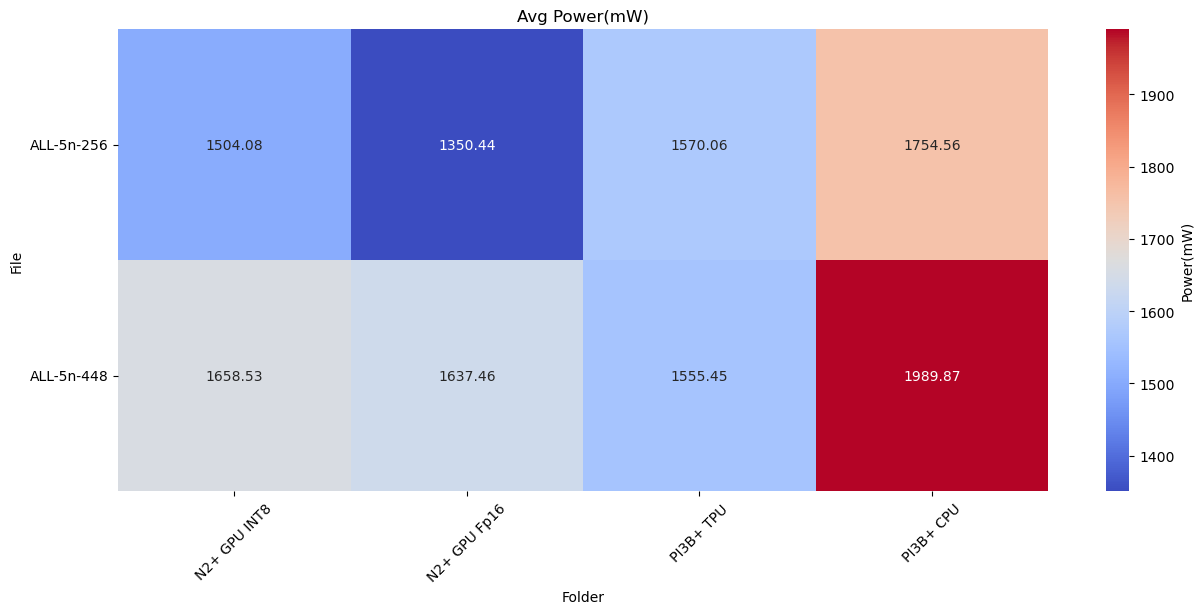

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def read_inference_files_in_folder(folder_path):
    all_data = []
    filenames = []
    for file in os.listdir(folder_path):
        if file.endswith('.txt') and 'start' in file:
            filepath = os.path.join(folder_path, file)
            with open(filepath, 'r') as f:
                lines = f.readlines()
                data = []
                for line in lines:
                    values = line.strip().split(',')
                    if len(values) == 15:
                        try:
                            data.append([float(x) for x in values if x != ''])
                        except ValueError:
                            continue
                all_data.append(pd.DataFrame(data))
                filenames.append(file)
    return all_data, filenames

def get_avg_highest_power(folder_name, dataframes, top_n=10):
    column = folder_power_column_index[folder_name]
    folder_values = []
    for df in dataframes:
        highest_values = df[column].nlargest(top_n).tolist()
        adjusted_values = [value - avg_standby_power[folder_name] for value in highest_values]
        folder_values.append(np.mean(adjusted_values))
    return folder_values
def get_median_new_data(folder_name, dataframes):
    column = folder_column_index[folder_name]
    folder_values = []
    for df in dataframes:
        median_value = df[column].median()
        adjusted_value = median_value - avg_standby_power[folder_name]
        folder_values.append(adjusted_value)
    return folder_values

def get_avg_power(folder_name, dataframes):
    column = folder_power_column_index[folder_name]
    folder_values = []
    for df in dataframes:
        mean_value = df[column].mean()
        adjusted_value = mean_value - avg_standby_power[folder_name]
        folder_values.append(adjusted_value)
    return folder_values

avg_standby_power = {
    'tpugpucomparisonfp16':2244.686,
    'tpugpucomparison': 2244.686,
    'tpucomparisonpower': 2244.667,
    'tpustandard': 2244.667,
}

folder_power_column_index = {
    'tpugpucomparison':12,
    'tpugpucomparisonfp16':12,
    'tpucomparisonpower':7,
    'tpustandard': 7,
}

folders = ['tpugpucomparison', 'tpugpucomparisonfp16','tpustandard', 'tpucomparisonpower']

all_avg_highest_power = []
file_names_list = []

max_files = 0
for folder in folders:
    data, filenames = read_inference_files_in_folder(folder)
    avg = get_avg_power(folder, data)
    max_files = max(max_files, len(avg))
    all_avg_highest_power.append(avg)
    file_names_list.append(filenames)


for i in range(len(all_avg_highest_power)):
    if len(all_avg_highest_power[i]) < max_files:
        all_avg_highest_power[i].extend([np.nan] * (max_files - len(all_avg_highest_power[i])))

heatmap_data = np.array(all_avg_highest_power)
print(file_names_list)
unique_filenames = []
for filenames in file_names_list:
    print
    for filename in filenames:
        if filename not in unique_filenames:
            unique_filenames.append(filename)

def create_heatmap(data, title, ylabel, xlabel, xticklabels, yticklabels, cbar_label):
    plt.figure(figsize=(15, 6))
    ax = sns.heatmap(data, annot=True, cmap="coolwarm", cbar_kws={'label': cbar_label}, fmt='.2f')  # Added the fmt parameter

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_xticklabels(xticklabels, rotation=45)
    ax.set_yticklabels(yticklabels, rotation=0)

    plt.show()


custom_y_labels = ['ALL-5n-256', 'ALL-5n-448', ]

heatmap_df = pd.DataFrame(heatmap_data)

"""
index1 = 10
index2 = 12
index3 = 11
index4 = 13

heatmap_df[[unique_filenames[index1], unique_filenames[index2]]] = heatmap_df[[unique_filenames[index2], unique_filenames[index1]]]
heatmap_df[[unique_filenames[index3], unique_filenames[index4]]] = heatmap_df[[unique_filenames[index4], unique_filenames[index3]]]

unique_filenames[index1], unique_filenames[index2] = unique_filenames[index2], unique_filenames[index1]
unique_filenames[index3], unique_filenames[index4] = unique_filenames[index4], unique_filenames[index3]
"""
heatmap_df = heatmap_df.T

unique_folder_names = ['N2+ GPU INT8', 'N2+ GPU Fp16', 'PI3B+ TPU', 'PI3B+ CPU']

create_heatmap(heatmap_df, "Avg Power(mW)", "File", "Folder", unique_folder_names, custom_y_labels, "Power(mW)")

heatmap_df.to_csv('peak_power_heatmap_data_smallimg.csv')



In [86]:
%pwd

'c:\\Users\\jspre\\year5project\\HCI'

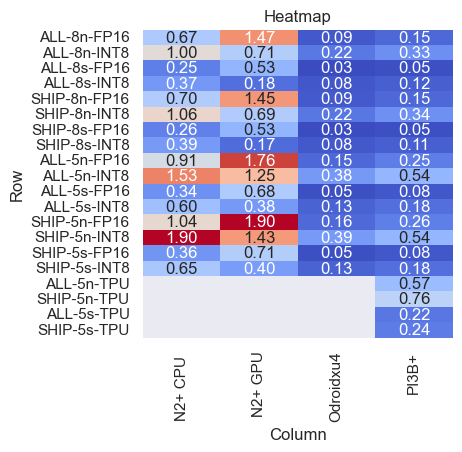

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
custom_y_labels = ['ALL-8n-FP16', 'ALL-8n-INT8', 'ALL-8s-FP16', 'ALL-8s-INT8', 'SHIP-8n-FP16', 'SHIP-8n-INT8', 'SHIP-8s-FP16', 'SHIP-8s-INT8','ALL-5n-FP16', 'ALL-5n-INT8', 'ALL-5s-FP16', 'ALL-5s-INT8', 'SHIP-5n-FP16', 'SHIP-5n-INT8', 'SHIP-5s-FP16', 'SHIP-5s-INT8','ALL-5n-TPU','SHIP-5n-TPU','ALL-5s-TPU','SHIP-5s-TPU']
folder_names = ['N2+ CPU ','N2+ GPU', 'Odroidxu4', 'PI3B+']

# Read the CSV file
data = pd.read_csv("fpsperwat.csv", header=None)

# Create a heatmap using Seaborn
sns.set()
plt.figure(figsize=(4, 4))
ax = sns.heatmap(data, annot=True, fmt=".2f", cmap="coolwarm",yticklabels=custom_y_labels,cbar=False)
ax.set_xticklabels(folder_names, rotation=90)

plt.title("Heatmap")
plt.xlabel("Column")
plt.ylabel("Row")
plt.show()


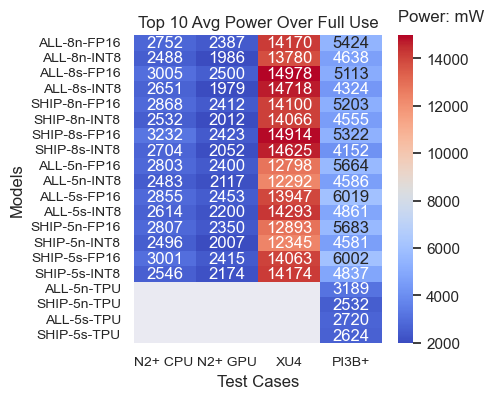

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
custom_y_labels = ['ALL-8n-FP16', 'ALL-8n-INT8', 'ALL-8s-FP16', 'ALL-8s-INT8', 'SHIP-8n-FP16', 'SHIP-8n-INT8', 'SHIP-8s-FP16', 'SHIP-8s-INT8','ALL-5n-FP16', 'ALL-5n-INT8', 'ALL-5s-FP16', 'ALL-5s-INT8', 'SHIP-5n-FP16', 'SHIP-5n-INT8', 'SHIP-5s-FP16', 'SHIP-5s-INT8','ALL-5n-TPU','SHIP-5n-TPU','ALL-5s-TPU','SHIP-5s-TPU']
folder_names = ['N2+ CPU ','N2+ GPU', 'XU4', 'PI3B+']

# Read the CSV file
data = pd.read_csv("csvfolders/peak_power_full.csv", header=None)

# Create a heatmap using Seaborn
sns.set()
plt.figure(figsize=(4, 4))

unit = 'm/s'

ax = sns.heatmap(data, annot=True, fmt=".0f", cmap="coolwarm", yticklabels=custom_y_labels, cbar=True, cbar_kws={'label': ' '})
ax.set_xticklabels(folder_names, rotation=0)

# Define the unit
unit = 'mW'

# Get the color bar object from the heatmap
cbar = ax.collections[0].colorbar

# Set the label for the color bar
cbar.ax.set_title(f'Power: {unit}', loc='left', pad=10)

ax.tick_params(axis='both', labelsize=10)  # Set the font size for both x and y tick labels
ax.tick_params(axis='x', labelsize=10)
plt.title("Top 10 Avg Power Over Full Use")
plt.xlabel("Test Cases")
plt.ylabel("Models")
plt.savefig('csvfolders/PeakPowernewnameFull.pdf', bbox_inches='tight', format='pdf')

plt.show()

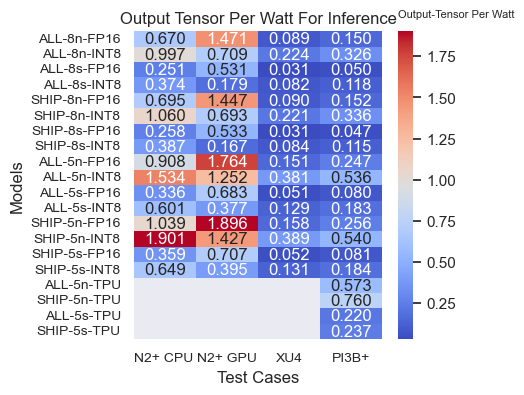

In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
custom_y_labels = ['ALL-8n-FP16', 'ALL-8n-INT8', 'ALL-8s-FP16', 'ALL-8s-INT8', 'SHIP-8n-FP16', 'SHIP-8n-INT8', 'SHIP-8s-FP16', 'SHIP-8s-INT8','ALL-5n-FP16', 'ALL-5n-INT8', 'ALL-5s-FP16', 'ALL-5s-INT8', 'SHIP-5n-FP16', 'SHIP-5n-INT8', 'SHIP-5s-FP16', 'SHIP-5s-INT8','ALL-5n-TPU','SHIP-5n-TPU','ALL-5s-TPU','SHIP-5s-TPU']
folder_names = ['N2+ CPU ','N2+ GPU', 'XU4', 'PI3B+']

# Read the CSV file
#data = pd.read_csv("csvfolders/avg_power_full.csv", header=None)
data = pd.read_csv("fpsperwat.csv", header=None)
# Create a heatmap using Seaborn
sns.set()
plt.figure(figsize=(4, 4))

unit = 'm/s'

ax = sns.heatmap(data, annot=True, fmt=".3f", cmap="coolwarm", yticklabels=custom_y_labels, cbar=True, cbar_kws={'label': ' '})
ax.set_xticklabels(folder_names, rotation=0)

# Define the unit
unit = 'OPW'

# Get the color bar object from the heatmap
cbar = ax.collections[0].colorbar

# Set the label for the color bar
#{unit}
cbar.ax.set_title(f'Output-Tensor Per Watt', loc='left', pad=10, fontsize=9)

ax.tick_params(axis='both', labelsize=10)  # Set the font size for both x and y tick labels
ax.tick_params(axis='x', labelsize=10)
plt.title("Output Tensor Per Watt For Inference")
plt.xlabel("Test Cases")
plt.ylabel("Models")
plt.savefig('csvfolders/FPSPERWATTInfer.pdf', bbox_inches='tight', format='pdf')

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'csvfolders/FPSPERWATTInfer.pdf'

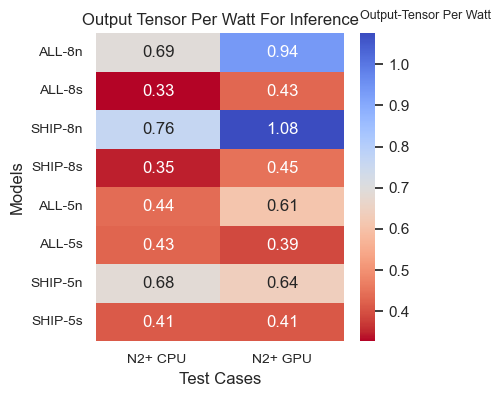

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
custom_y_labels = ['ALL-8n', 'ALL-8s', 'SHIP-8n', 'SHIP-8s', 'ALL-5n', 'ALL-5s', 'SHIP-5n', 'SHIP-5s']
folder_names = ['N2+ CPU ','N2+ GPU']

# Read the CSV file
#data = pd.read_csv("csvfolders/avg_power_full.csv", header=None)
data = pd.read_csv("FPSPERWATTNMSCSV.csv", header=None)
# Create a heatmap using Seaborn
sns.set()
plt.figure(figsize=(4, 4))

unit = 'm/s'

ax = sns.heatmap(data, annot=True, fmt=".2f", cmap="coolwarm_r", yticklabels=custom_y_labels, cbar=True, cbar_kws={'label': ' '})
ax.set_xticklabels(folder_names, rotation=0)

# Define the unit
unit = 'OPW'

# Get the color bar object from the heatmap
cbar = ax.collections[0].colorbar

# Set the label for the color bar
#{unit}
cbar.ax.set_title(f'Output-Tensor Per Watt', loc='left', pad=10, fontsize=9)

ax.tick_params(axis='both', labelsize=10)  # Set the font size for both x and y tick labels
ax.tick_params(axis='x', labelsize=10)
plt.title("Output Tensor Per Watt For Inference")
plt.xlabel("Test Cases")
plt.ylabel("Models")
plt.savefig('csvfolders/FPSPERWATTInfer.pdf', bbox_inches='tight', format='pdf')

plt.show()


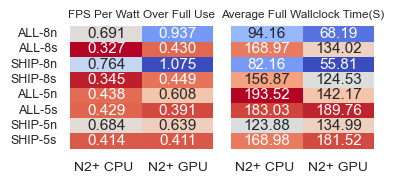

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

custom_y_labels = ['ALL-8n', 'ALL-8s', 'SHIP-8n', 'SHIP-8s', 'ALL-5n', 'ALL-5s', 'SHIP-5n', 'SHIP-5s']
folder_names = ['N2+ CPU ','N2+ GPU']

# Read the CSV files
#data1 = pd.read_csv("fpsperwat.csv", header=None)
data1 = pd.read_csv("FPSPERWATTNMSCSV.csv", header=None)
data2 = pd.read_csv("TIMEALLNMS.csv", header=None)

# Create a figure with two subplots sharing a y-axis
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(4, 2), sharey=True)


# Create a heatmap for each dataset and associate them with their respective subplots
sns.heatmap(data1, annot=True, fmt=".3f", cmap="coolwarm_r", yticklabels=custom_y_labels, cbar=False, ax=ax1,annot_kws={"size": 11})
sns.heatmap(data2, annot=True, fmt=".2f", cmap="coolwarm", yticklabels=custom_y_labels, cbar=False, ax=ax2,annot_kws={"size": 11})

# Customize the appearance of the heatmaps and the shared y-axis
ax1.set_xticklabels(folder_names, rotation=0)
ax2.set_xticklabels(folder_names, rotation=0)
ax1.tick_params(axis='both', labelsize=9)  # Set the font size for both x and y tick labels
ax1.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='x', labelsize=10)  #

ax1.set_title("FPS Per Watt Over Full Use", fontsize=8.5)
ax2.set_title("Average Full Wallclock Time(S)", fontsize=8.5)

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig('heatmaps.pdf', bbox_inches='tight', format='pdf')


plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
custom_y_labels = ['ALL-8n-FP16', 'ALL-8n-INT8', 'ALL-8s-FP16', 'ALL-8s-INT8', 'SHIP-8n-FP16', 'SHIP-8n-INT8', 'SHIP-8s-FP16', 'SHIP-8s-INT8','ALL-5n-FP16', 'ALL-5n-INT8', 'ALL-5s-FP16', 'ALL-5s-INT8', 'SHIP-5n-FP16', 'SHIP-5n-INT8', 'SHIP-5s-FP16', 'SHIP-5s-INT8','ALL-5n-TPU','SHIP-5n-TPU','ALL-5s-TPU','SHIP-5s-TPU']
folder_names = ['N2+ CPU ','N2+ GPU', 'XU4', 'PI3B+']

# Read the CSV file
#data = pd.read_csv("csvfolders/avg_power_full.csv", header=None)
data = pd.read_csv("OLD/fpsperwat.csv", header=None)
# Create a heatmap using Seaborn
sns.set()
plt.figure(figsize=(4, 4))

unit = 'm/s'

ax = sns.heatmap(data, annot=True, fmt=".3f", cmap="coolwarm", yticklabels=custom_y_labels, cbar=True, cbar_kws={'label': ' '})
ax.set_xticklabels(folder_names, rotation=0)

# Define the unit
unit = 'OPW'

# Get the color bar object from the heatmap
cbar = ax.collections[0].colorbar

# Set the label for the color bar
#{unit}
cbar.ax.set_title(f'Output-Tensor Per Watt', loc='left', pad=10, fontsize=9)

ax.tick_params(axis='both', labelsize=10)  # Set the font size for both x and y tick labels
ax.tick_params(axis='x', labelsize=10)
plt.title("Output Tensor Per Watt For Inference")
plt.xlabel("Test Cases")
plt.ylabel("Models")
plt.savefig('csvfolders/FPSPERWATTInfer.pdf', bbox_inches='tight', format='pdf')

plt.show()


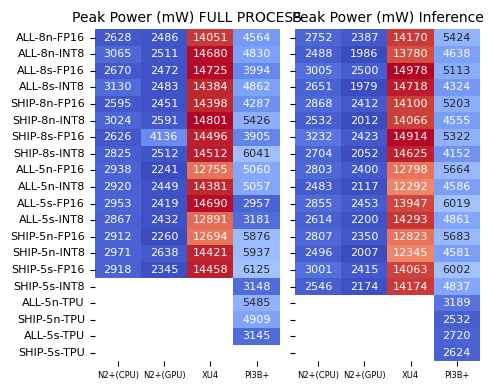

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

custom_y_labels = ['ALL-8n-FP16', 'ALL-8n-INT8', 'ALL-8s-FP16', 'ALL-8s-INT8', 'SHIP-8n-FP16', 'SHIP-8n-INT8', 'SHIP-8s-FP16', 'SHIP-8s-INT8','ALL-5n-FP16', 'ALL-5n-INT8', 'ALL-5s-FP16', 'ALL-5s-INT8', 'SHIP-5n-FP16', 'SHIP-5n-INT8', 'SHIP-5s-FP16', 'SHIP-5s-INT8','ALL-5n-TPU','SHIP-5n-TPU','ALL-5s-TPU','SHIP-5s-TPU']
folder_names = ['N2+(CPU)','N2+(GPU)', 'XU4', 'PI3B+']

# Read the CSV files
#data1 = pd.read_csv("fpsperwat.csv", header=None)
data1 = pd.read_csv("csvfolders/peak_power_full.csv")
data2 = pd.read_csv("peakpower.csv", header=None)

# Create a figure with two subplots sharing a y-axis
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(5, 4), sharey=True)


# Create a heatmap for each dataset and associate them with their respective subplots
sns.heatmap(data1, annot=True, fmt=".0f", cmap="coolwarm", yticklabels=custom_y_labels, cbar=False, ax=ax1,annot_kws={"size": 8})
sns.heatmap(data2, annot=True, fmt=".0f", cmap="coolwarm", yticklabels=custom_y_labels, cbar=False, ax=ax2,annot_kws={"size": 8})

# Customize the appearance of the heatmaps and the shared y-axis
ax1.set_xticklabels(folder_names, rotation=0)
ax2.set_xticklabels(folder_names, rotation=0)
ax1.tick_params(axis='both', labelsize=8)  # Set the font size for both x and y tick labels
ax1.tick_params(axis='x', labelsize=6)
ax2.tick_params(axis='x', labelsize=6)  #

ax1.set_title("Peak Power (mW) FULL PROCESS", fontsize=10)
ax2.set_title("Peak Power (mW) Inference", fontsize=10)

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig('heatmaps.pdf', bbox_inches='tight', format='pdf')


plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

custom_y_labels = ['ALL-8n-FP16', 'ALL-8n-INT8', 'ALL-8s-FP16', 'ALL-8s-INT8', 'SHIP-8n-FP16', 'SHIP-8n-INT8', 'SHIP-8s-FP16', 'SHIP-8s-INT8','ALL-5n-FP16', 'ALL-5n-INT8', 'ALL-5s-FP16', 'ALL-5s-INT8', 'SHIP-5n-FP16', 'SHIP-5n-INT8', 'SHIP-5s-FP16', 'SHIP-5s-INT8','ALL-5n-TPU','SHIP-5n-TPU','ALL-5s-TPU','SHIP-5s-TPU']
folder_names = ['N2+(CPU)','N2+(GPU)', 'XU4', 'PI3B+']

# Read the CSV files
#data1 = pd.read_csv("fpsperwat.csv", header=None)
data1 = pd.read_csv("csvfolders/peak_power_full.csv")
data2 = pd.read_csv("peakpower.csv", header=None)

# Create a figure with two subplots sharing a y-axis
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(5, 4), sharey=True)


# Create a heatmap for each dataset and associate them with their respective subplots
sns.heatmap(data1, annot=True, fmt=".0f", cmap="coolwarm", yticklabels=custom_y_labels, cbar=False, ax=ax1,annot_kws={"size": 8})
sns.heatmap(data2, annot=True, fmt=".0f", cmap="coolwarm", yticklabels=custom_y_labels, cbar=False, ax=ax2,annot_kws={"size": 8})

# Customize the appearance of the heatmaps and the shared y-axis
ax1.set_xticklabels(folder_names, rotation=0)
ax2.set_xticklabels(folder_names, rotation=0)
ax1.tick_params(axis='both', labelsize=8)  # Set the font size for both x and y tick labels
ax1.tick_params(axis='x', labelsize=6)
ax2.tick_params(axis='x', labelsize=6)  #

ax1.set_title("Peak Power (mW) FULL PROCESS", fontsize=10)
ax2.set_title("Peak Power (mW) Inference", fontsize=10)

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig('heatmaps.pdf', bbox_inches='tight', format='pdf')


plt.tight_layout()
plt.show()


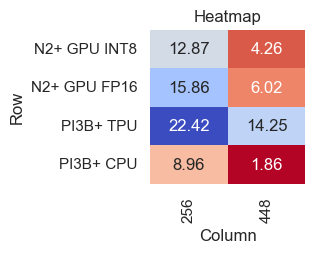

In [120]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
folder_names = ['256', '448']
custom_y_labels= ['N2+ GPU INT8','N2+ GPU FP16', 'PI3B+ TPU', 'PI3B+ CPU']

# Read the CSV file
data = pd.read_csv("FPSPERWATTSMALLIMG.csv", header=None)

# Create a heatmap using Seaborn
sns.set()
plt.figure(figsize=(2, 2))
ax = sns.heatmap(data, annot=True, fmt=".2f", cmap="coolwarm_r",yticklabels=custom_y_labels,cbar=False)
ax.set_xticklabels(folder_names, rotation=90)

plt.title("Heatmap")
plt.xlabel("Column")
plt.ylabel("Row")
plt.show()


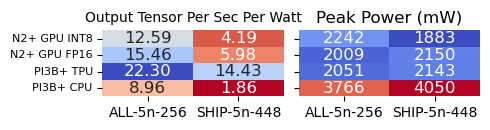

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
folder_names = ['ALL-5n-256', 'SHIP-5n-448']
custom_y_labels= ['N2+ GPU INT8','N2+ GPU FP16', 'PI3B+ TPU', 'PI3B+ CPU']

# Read the CSV files
data1 = pd.read_csv("OLD/FPSPERWATTSMALLIMG.csv", header=None)
data2 = pd.read_csv("OLD/peak_power_heatmap_data_smallimg - Copy.csv", header=None)

# Create a figure with two subplots sharing a y-axis
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(5, 1.4), sharey=True)


# Create a heatmap for each dataset and associate them with their respective subplots
sns.heatmap(data1, annot=True, fmt=".2f", cmap="coolwarm_r", yticklabels=custom_y_labels, cbar=False, ax=ax1,annot_kws={"size": 12})
sns.heatmap(data2, annot=True, fmt=".0f", cmap="coolwarm", yticklabels=custom_y_labels, cbar=False, ax=ax2,annot_kws={"size": 12})

# Customize the appearance of the heatmaps and the shared y-axis
ax1.set_xticklabels(folder_names, rotation=0)
ax2.set_xticklabels(folder_names, rotation=0)
ax1.tick_params(axis='both', labelsize=8)  # Set the font size for both x and y tick labels
ax1.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='x', labelsize=10)  #


ax1.set_title("Output Tensor Per Sec Per Watt", fontsize=10)
ax2.set_title("Peak Power (mW)")

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig('heatmaps.pdf', bbox_inches='tight', format='pdf')


plt.tight_layout()
plt.show()


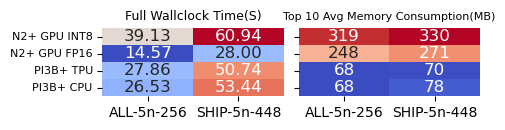

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
folder_names = ['ALL-5n-256', 'SHIP-5n-448']
custom_y_labels= ['N2+ GPU INT8','N2+ GPU FP16', 'PI3B+ TPU', 'PI3B+ CPU']

# Read the CSV files
data1 = pd.read_csv("OLD/TotalTime_smallimg.csv", header=None)
data2 = pd.read_csv("OLD/PeakMemorySmall.csv", header=None)

# Create a figure with two subplots sharing a y-axis
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(5, 1.4), sharey=True)


# Create a heatmap for each dataset and associate them with their respective subplots
sns.heatmap(data1, annot=True, fmt=".2f", cmap="coolwarm", yticklabels=custom_y_labels, cbar=False, ax=ax1,annot_kws={"size": 12})
sns.heatmap(data2, annot=True, fmt=".0f", cmap="coolwarm", yticklabels=custom_y_labels, cbar=False, ax=ax2,annot_kws={"size": 12})

# Customize the appearance of the heatmaps and the shared y-axis
ax1.set_xticklabels(folder_names, rotation=0)
ax2.set_xticklabels(folder_names, rotation=0)
ax1.tick_params(axis='both', labelsize=8)  # Set the font size for both x and y tick labels
ax1.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='x', labelsize=10)  #


ax1.set_title("Full Wallclock Time(S)", fontsize=9)
ax2.set_title("Top 10 Avg Memory Consumption(MB)",fontsize=8)

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig('heatmaps2.pdf', bbox_inches='tight', format='pdf')


plt.tight_layout()
plt.show()


In [3]:
%pwd

'c:\\Users\\jspre\\year5project\\HCI'

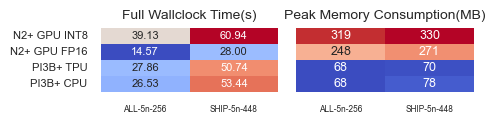

In [182]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
folder_names = ['ALL-5n-256', 'SHIP-5n-448']
custom_y_labels= ['N2+ GPU INT8','N2+ GPU FP16', 'PI3B+ TPU', 'PI3B+ CPU']

# Read the CSV files
data1 = pd.read_csv("TotalTime_smallimg.csv", header=None)
data2 = pd.read_csv("Peak_memory_smallimg.csv", header=None)

# Create a figure with two subplots sharing a y-axis
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(5, 1.4), sharey=True)


# Create a heatmap for each dataset and associate them with their respective subplots
sns.heatmap(data1, annot=True, fmt=".2f", cmap="coolwarm", yticklabels=custom_y_labels, cbar=False, ax=ax1,annot_kws={"size": 8})
sns.heatmap(data2, annot=True, fmt=".0f", cmap="coolwarm", yticklabels=custom_y_labels, cbar=False, ax=ax2,annot_kws={"size": 9})

# Customize the appearance of the heatmaps and the shared y-axis
ax1.set_xticklabels(folder_names, rotation=0)
ax2.set_xticklabels(folder_names, rotation=0)
ax1.tick_params(axis='both', labelsize=8)  # Set the font size for both x and y tick labels
ax1.tick_params(axis='x', labelsize=6)
ax2.tick_params(axis='x', labelsize=6)  #


ax1.set_title("Full Wallclock Time(s)", fontsize=10)
ax2.set_title("Peak Memory Consumption(MB)", fontsize=10)

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig('Peak MEM and TIME.pdf', bbox_inches='tight', format='pdf')


plt.tight_layout()
plt.show()


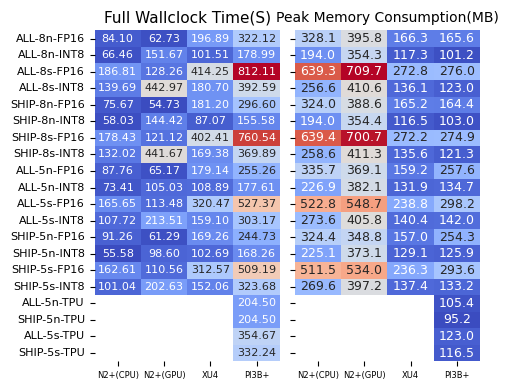

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

custom_y_labels = ['ALL-8n-FP16', 'ALL-8n-INT8', 'ALL-8s-FP16', 'ALL-8s-INT8', 'SHIP-8n-FP16', 'SHIP-8n-INT8', 'SHIP-8s-FP16', 'SHIP-8s-INT8','ALL-5n-FP16', 'ALL-5n-INT8', 'ALL-5s-FP16', 'ALL-5s-INT8', 'SHIP-5n-FP16', 'SHIP-5n-INT8', 'SHIP-5s-FP16', 'SHIP-5s-INT8','ALL-5n-TPU','SHIP-5n-TPU','ALL-5s-TPU','SHIP-5s-TPU']
folder_names = ['N2+(CPU)','N2+(GPU)', 'XU4', 'PI3B+']

# Read the CSV files
data1 = pd.read_csv("TOTAL_WALLCLOCK_heatmap_data.csv", header=None)
data2 = pd.read_csv("peak_memory_heatmap_data.csv", header=None)

# Create a figure with two subplots sharing a y-axis
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(5, 4), sharey=True)


# Create a heatmap for each dataset and associate them with their respective subplots
sns.heatmap(data1, annot=True, fmt=".2f", cmap="coolwarm", yticklabels=custom_y_labels, cbar=False, ax=ax1,annot_kws={"size": 8})
sns.heatmap(data2, annot=True, fmt=".1f", cmap="coolwarm", yticklabels=custom_y_labels, cbar=False, ax=ax2,annot_kws={"size": 9})

# Customize the appearance of the heatmaps and the shared y-axis
ax1.set_xticklabels(folder_names, rotation=0)
ax2.set_xticklabels(folder_names, rotation=0)
ax1.tick_params(axis='both', labelsize=8)  # Set the font size for both x and y tick labels
ax1.tick_params(axis='x', labelsize=6)
ax2.tick_params(axis='x', labelsize=6)  #

ax1.set_title("Full Wallclock Time(S)", fontsize=11)
ax2.set_title("Peak Memory Consumption(MB)", fontsize=10)

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig('peakmemory and Time.pdf', bbox_inches='tight', format='pdf')


plt.tight_layout()
plt.show()


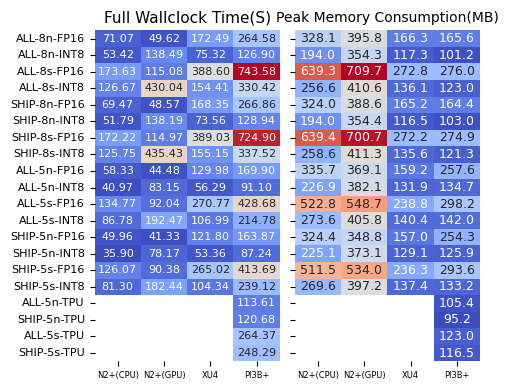

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

custom_y_labels = ['ALL-8n-FP16', 'ALL-8n-INT8', 'ALL-8s-FP16', 'ALL-8s-INT8', 'SHIP-8n-FP16', 'SHIP-8n-INT8', 'SHIP-8s-FP16', 'SHIP-8s-INT8','ALL-5n-FP16', 'ALL-5n-INT8', 'ALL-5s-FP16', 'ALL-5s-INT8', 'SHIP-5n-FP16', 'SHIP-5n-INT8', 'SHIP-5s-FP16', 'SHIP-5s-INT8','ALL-5n-TPU','SHIP-5n-TPU','ALL-5s-TPU','SHIP-5s-TPU']
folder_names = ['N2+(CPU)','N2+(GPU)', 'XU4', 'PI3B+']

# Read the CSV files
data1 = pd.read_csv("FULLTIMEnoPostProcessing.csv", header=None)
data2 = pd.read_csv("peak_memory_heatmap_data.csv", header=None)

# Create a figure with two subplots sharing a y-axis
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(5, 4), sharey=True)


# Create a heatmap for each dataset and associate them with their respective subplots
sns.heatmap(data1, annot=True, fmt=".2f", cmap="coolwarm", yticklabels=custom_y_labels, cbar=False, ax=ax1,annot_kws={"size": 8})
sns.heatmap(data2, annot=True, fmt=".1f", cmap="coolwarm", yticklabels=custom_y_labels, cbar=False, ax=ax2,annot_kws={"size": 9})

# Customize the appearance of the heatmaps and the shared y-axis
ax1.set_xticklabels(folder_names, rotation=0)
ax2.set_xticklabels(folder_names, rotation=0)
ax1.tick_params(axis='both', labelsize=8)  # Set the font size for both x and y tick labels
ax1.tick_params(axis='x', labelsize=6)
ax2.tick_params(axis='x', labelsize=6)  #

ax1.set_title("Full Wallclock Time(S)", fontsize=11)
ax2.set_title("Peak Memory Consumption(MB)", fontsize=10)

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig('peakmemory and Time(no post proccessing).pdf', bbox_inches='tight', format='pdf')


plt.tight_layout()
plt.show()
